In [1]:
import argparse
from datetime import datetime

import torch
import torch.nn as nn
import torchtext

import matplotlib.pyplot as plt

from train import train, validate
from models import Encoder, Decoder, Discriminator
from utils import tokenizer, print_sample, print_decoded
from dataset import Multi30KEminem

%matplotlib inline

/cephfs/home/seliverstov/oml2/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cephfs/home/seliverstov/oml2/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [2]:
seed = 42
batch_size = 64
hidden_size = 500
embeddings_size = 300
vectors = 'fasttext.en.300d'
dropout = 0.3
prior_size = 2 * hidden_size
learning_rate =1e-4

In [3]:
torch.manual_seed(seed)

In [4]:
if torch.cuda.is_available():
    device_num = 6
    device = f"cuda:{device_num}"
else:
    device_num = -1
    device = "cpu"

In [5]:
Multi30KEminem.download('.')

'./multi30k_eminem_4l/'

In [6]:
TEXT = torchtext.data.Field(eos_token='<eos>',
                                init_token='<sos>',
                                tokenize=tokenizer,
                                lower=True)

LABEL = torchtext.data.Field(sequential=False, unk_token=None)

In [7]:
train_ds, valid_ds, _ = Multi30KEminem.splits(TEXT, LABEL, '.')

In [8]:
TEXT.build_vocab(train_ds)
LABEL.build_vocab(train_ds)

vocab_size = len(TEXT.vocab)

label_size = len(LABEL.vocab)

In [9]:
train_dl = torchtext.data.Iterator(train_ds, batch_size, repeat=False, shuffle=False, device=device_num)
valid_dl = torchtext.data.Iterator(valid_ds, batch_size, repeat=False, device=device_num)
gen_dl = torchtext.data.Iterator(train_ds, 1, repeat=False, device=device_num)

if vectors:
    TEXT.vocab.load_vectors(vectors)

In [10]:
enc = Encoder(vocab_size, embeddings_size, hidden_size, n_layers=3,
                  dropout=dropout, lr=learning_rate, vectors=TEXT.vocab.vectors).to(device)

dec = Decoder(vocab_size, embeddings_size, hidden_size, prior_size + label_size, n_layers=3,
              dropout=dropout, lr=learning_rate, vectors=TEXT.vocab.vectors).to(device)

disc = Discriminator([prior_size + label_size, hidden_size, 1],
                     dropout=0.3, lr=learning_rate, activation_fn=nn.LeakyReLU(0.2)).to(device)



In [11]:
print("========== Encoder ==========\n{}".format(enc))

========== Encoder ==========
Encoder(
  (emb): Embedding(17469, 300)
  (rnn): LSTM(300, 500, num_layers=3, dropout=0.3, bidirectional=True)
)


In [12]:
print("========== Decoder ==========\n{}".format(dec))

========== Decoder ==========
Decoder(
  (emb): Embedding(17469, 300)
  (rnn): LSTM(1302, 500, num_layers=3, dropout=0.3)
  (fc): Linear(in_features=500, out_features=17469, bias=True)
)


In [13]:
print("========== Discriminator ==========\n{}".format(disc))

========== Discriminator ==========
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=1002, out_features=500, bias=True)
    (1): Dropout(p=0.3)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=500, out_features=1, bias=True)
  )
)


In [14]:
def plot_metrics(metrics, idx = 0, metric_name = 'Loss'):
    plt.figure(figsize=(20,10))
    for model, (trn, val, tst) in metrics.items():
        trn = [metric[idx] for metric in trn]
        val = [metric[idx] for metric in val]
        tst = [metric[idx] for metric in tst]
        if trn:
            plt.plot(trn, label=f'{model} Train')
        if val:
            plt.plot(val, label=f'{model} Valid', marker='v')
        if tst:
            plt.plot(tst, label=f'{model} Test', marker='o')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel(metric_name)
    plt.show()

In [15]:
model_name ='RCAAE'
metrics = {model_name: ([], [], [])}

========== Start epoch 1 at 21:49:38 ==========
Epoch   1 Train: BLEU: 28.33, AE: 5.02258, G: 5.29771, D: 2.40285 at 21:57:54
Epoch   1 Valid: BLEU: 32.74, AE: 4.48867, G: 5.12280, D: 0.97675 at 21:58:05

Origin:
	time for me to just stand up and travel new land
	time to leave and just take matters into my own hands
	once i 'm over these track man i 'm a never look back
	and i 'm gone and i know right where i 'm goin <eos>

Decoded: a a a a a a a a a a a
	<nl>
	<nl>
	<nl>
	<nl>
	<nl>
	<nl>
	<nl>
	<nl>
	<nl>
	<nl>
	<nl>
	<nl> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
	

Random sample:

Decoded w. style E:
	a a a a a a a a a a a
	<nl>
	<nl>
	<nl>
	<nl>
	<nl>
	<nl>
	<nl>
	<nl>
	<nl>
	<nl>
	a <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

Decoded w. style M:
	a a a a a a a a a a a
	<nl>
	<nl>
	<nl>
	<nl>
	<nl>
	<nl>
	<nl>
	<nl>
	<nl>
	<nl>
	a <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

========== Start epoch 2 at 21:58:05 =======

Epoch  11 Train: BLEU: 36.26, AE: 3.18478, G: 3.87193, D: 0.71066 at 23:21:51
Epoch  11 Valid: BLEU: 40.25, AE: 3.18920, G: 3.91647, D: 0.68655 at 23:22:02

Origin:
	a woman is weaving with a comb in her hand .
	a painter on a ladder paints the brick exterior blue .
	the blond woman is crouching in a field of pink tulips , near a grassy field and trees . <eos>

Decoded: and i 'm a little girl , i 'm a little bit of the
	and i 'm a little man , i 'm a little bit of the
	and i 'm a little man , i 'm a little bit of the
	

Random sample:

Decoded w. style E:
	i 'm a little bit of the world
	and i 'm a little bit of the world
	and i 'm a little bit , i 'm a little bit of the background <eos>

Decoded w. style M:
	a man in a blue shirt is playing a street .
	a man in a blue shirt is playing a red of a white shirt .
	a man is a blue shirt is playing a street . <eos>

========== Start epoch 12 at 23:22:02 ==========
Epoch  12 Train: BLEU: 36.42, AE: 3.12830, G: 3.81473, D: 0.71394 at 23:30:16

Epoch  20 Train: BLEU: 37.31, AE: 2.78997, G: 3.47790, D: 0.71945 at 00:37:08
Epoch  20 Valid: BLEU: 40.13, AE: 2.95380, G: 3.63923, D: 0.71309 at 00:37:19

Origin:
	two children are riding on the back of a three wheel scooter driven by a young lady in pink .
	a building has a bee painted on the roof .
	blond children sleep on an adults lap as they ride on a bus . <eos>

Decoded: two men are playing a game in a field .
	a man in a blue shirt and a blue shirt is sitting on a bench in a chair .
	a man in a blue shirt is playing a guitar on a sidewalk . <eos>
	

Random sample:

Decoded w. style E:
	and the two of us ,
	i 'm a little bit of a bit of dignity
	i 'm a little bit of dignity
	i 'm a little bit of dignity <eos>

Decoded w. style M:
	two men are playing a game on a street .
	a man in a blue shirt is playing a guitar .
	a man in a blue shirt is playing a guitar . <eos>



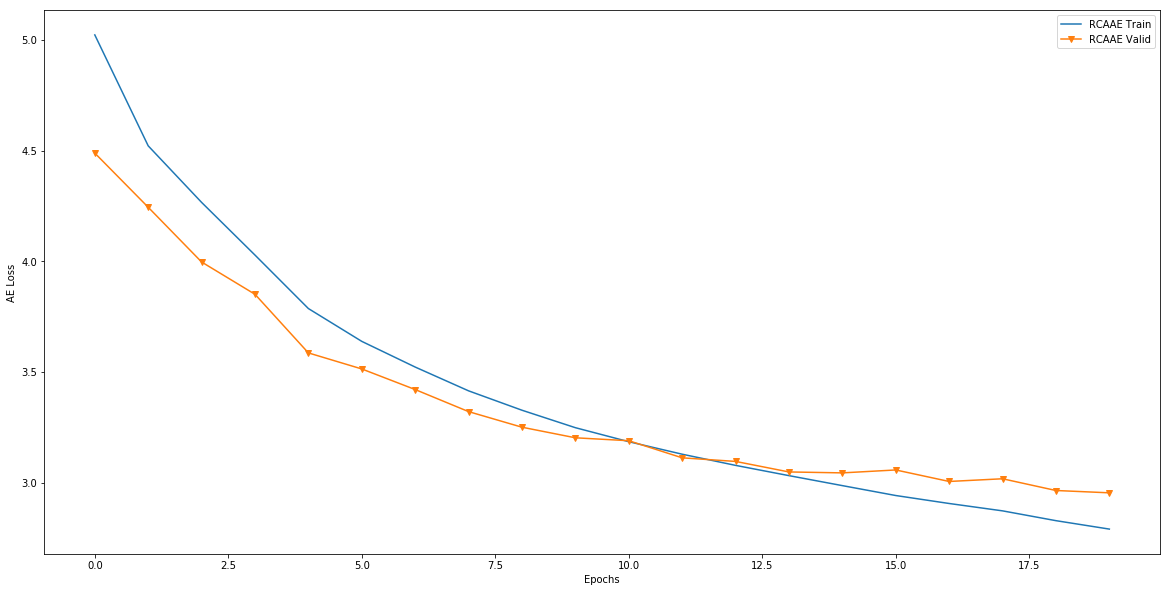

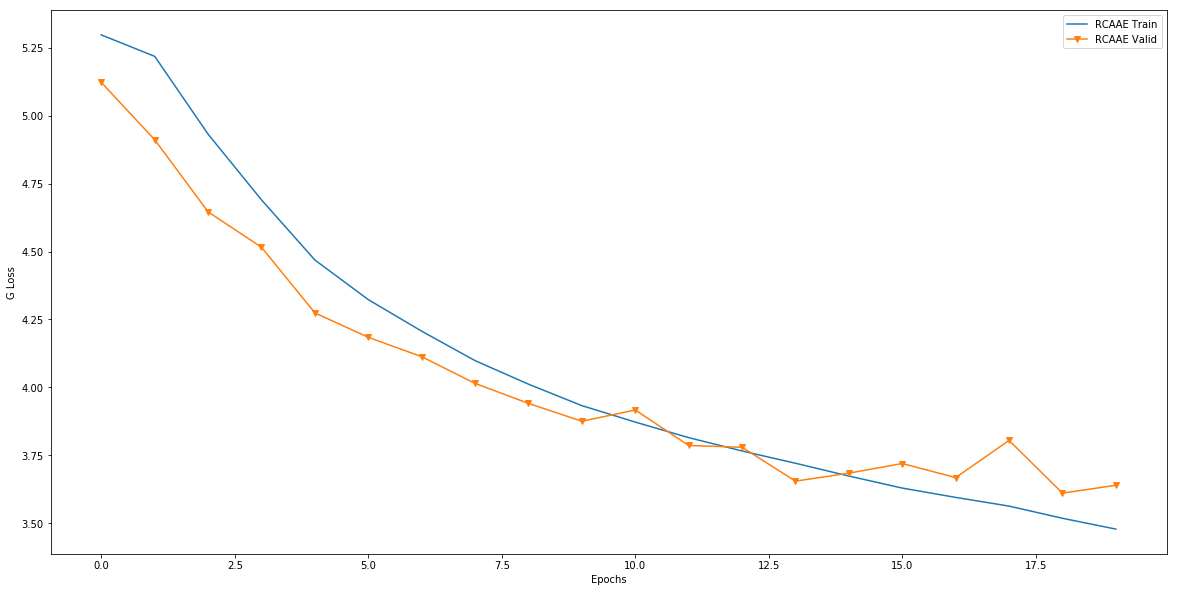

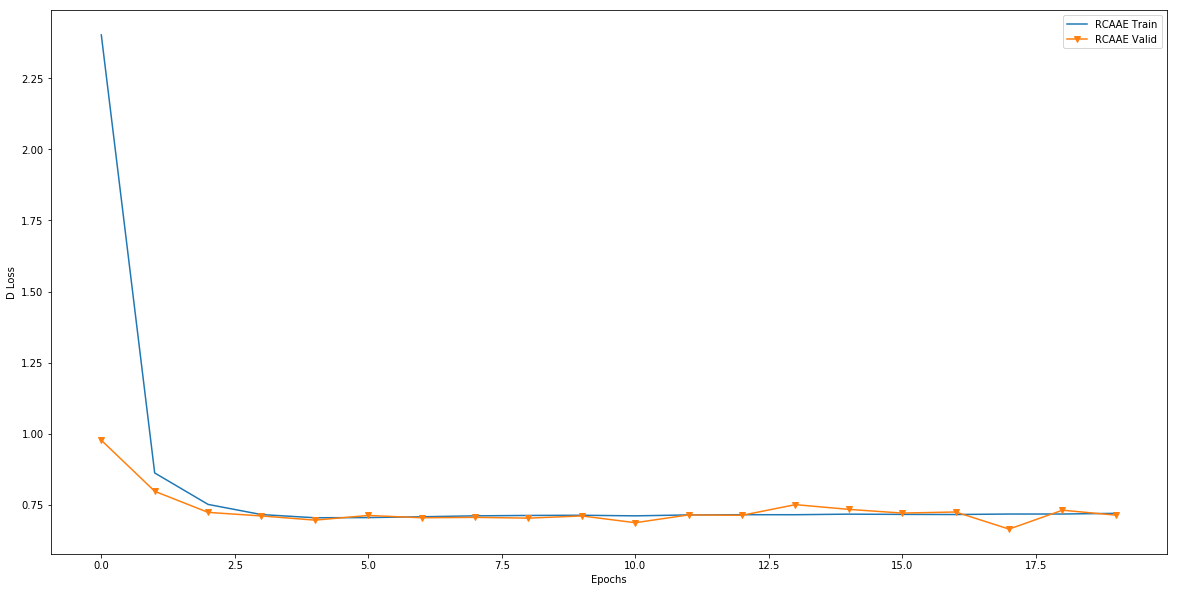

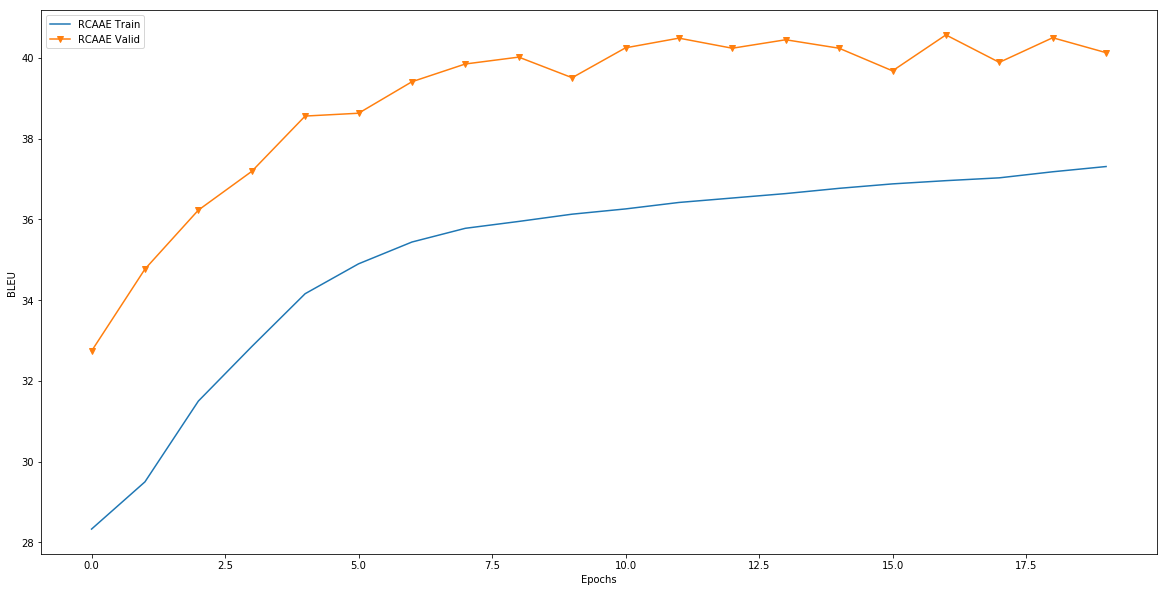

========== Start epoch 21 at 00:37:20 ==========
Epoch  21 Train: BLEU: 37.45, AE: 2.75230, G: 3.44111, D: 0.71746 at 00:45:34
Epoch  21 Valid: BLEU: 40.22, AE: 2.95430, G: 3.63268, D: 0.71146 at 00:45:44

Origin:
	shady man no do n't massacre the fans
	damn , i think kim kardashians a man
	she stomped him just cause he asked to put his hands
	on her massive gluteus maximus again <eos>

Decoded: and i 'm a buster
	i 'm a little bit of dignity
	i 'm a little bit of dignity
	i 'm a little bit of a bit of dignity , i 'm a criminal
	

Random sample:

Decoded w. style E:
	and i 'm a buster
	i 'm a little bit of dignity
	i 'm a little bit of dignity
	i 'm a little bit of a bit of dignity <eos>

Decoded w. style M:
	two men are playing a game on a game .
	a man in a blue shirt is playing a guitar .
	a man in a blue shirt is playing a guitar . <eos>

========== Start epoch 22 at 00:45:44 ==========
Epoch  22 Train: BLEU: 37.56, AE: 2.71986, G: 3.40911, D: 0.71865 at 00:53:56
Epoch  22 Valid: B


Decoded w. style M:
	an older man in a blue shirt is playing a guitar .
	a man in a blue shirt is standing on a bench with a red and white and white and white .
	a man is playing a guitar

========== Start epoch 31 at 02:01:09 ==========
Epoch  31 Train: BLEU: 38.84, AE: 2.46507, G: 3.15481, D: 0.71893 at 02:09:12
Epoch  31 Valid: BLEU: 41.72, AE: 2.81720, G: 3.50232, D: 0.70799 at 02:09:23

Origin:
	but i 'm your biggest fan
	i even got the underground shit that you did with scam
	i got a room full of your posters
	and your pictures man <eos>

Decoded: you 're a fuckin ' joke , you 're a fuckin ' joke
	i 'm a criminal
	i 'm a criminal , i 'm a criminal
	i 'm a criminal
	

Random sample:

Decoded w. style E:
	and i 'm a doberman , and i 'm a fiend
	i 'm a fiend , i 'm a fiend
	i 'm a soldier
	i 'm a doberman , i 'm a fiend , i 'm a fiend

Decoded w. style M:
	a group of people are playing soccer .
	a man in a blue shirt and a black shirt is sitting on a bench .
	a man in a blue shirt 

Epoch  40 Train: BLEU: 40.42, AE: 2.26769, G: 2.95950, D: 0.71641 at 03:22:56
Epoch  40 Valid: BLEU: 42.43, AE: 2.75882, G: 3.36447, D: 0.75056 at 03:23:06

Origin:
	a girl with a red shirt is running in the grass .
	the baby in suspenders sits by a toy .
	a man and two woman eating food at a local festival . <eos>

Decoded: a young boy in a blue shirt is playing a guitar .
	a group of people are standing in a circle with a group of people .
	a group of people are standing on
	

Random sample:

Decoded w. style E:
	a little girl and i 'm a fiend , and i 'm a fiend
	i 'm tired of committing a couple of screws
	i 'm tired of being knots and i 'm on
	i 'm tired of being

Decoded w. style M:
	a young man is sitting on a bench with a microphone .
	a group of people are standing on a stage , one is holding a red and white and white and white .
	a group of people are



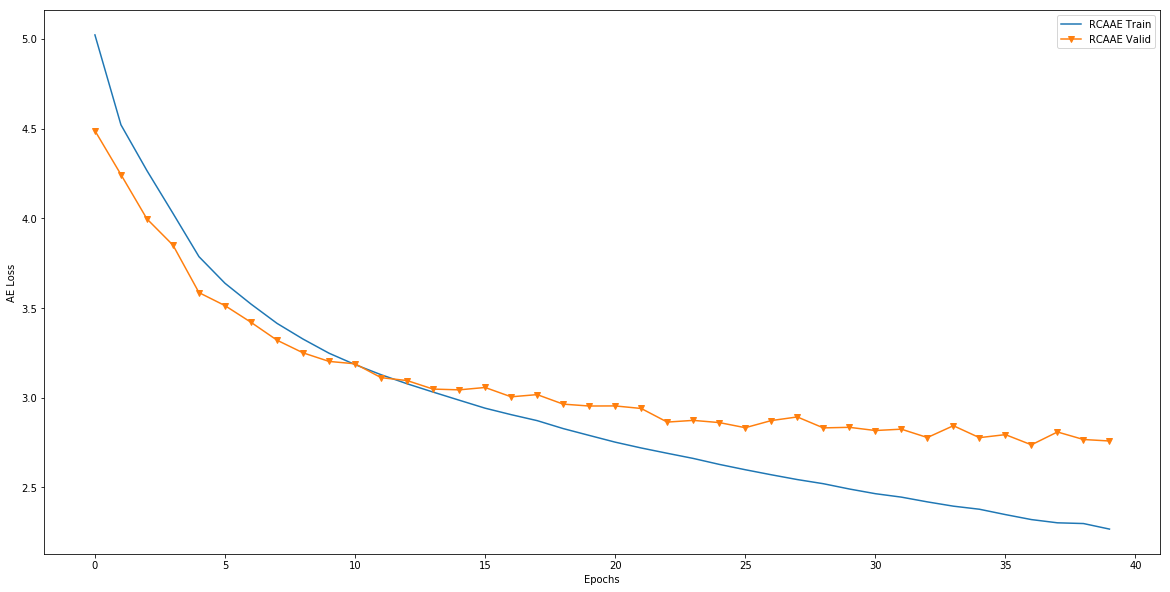

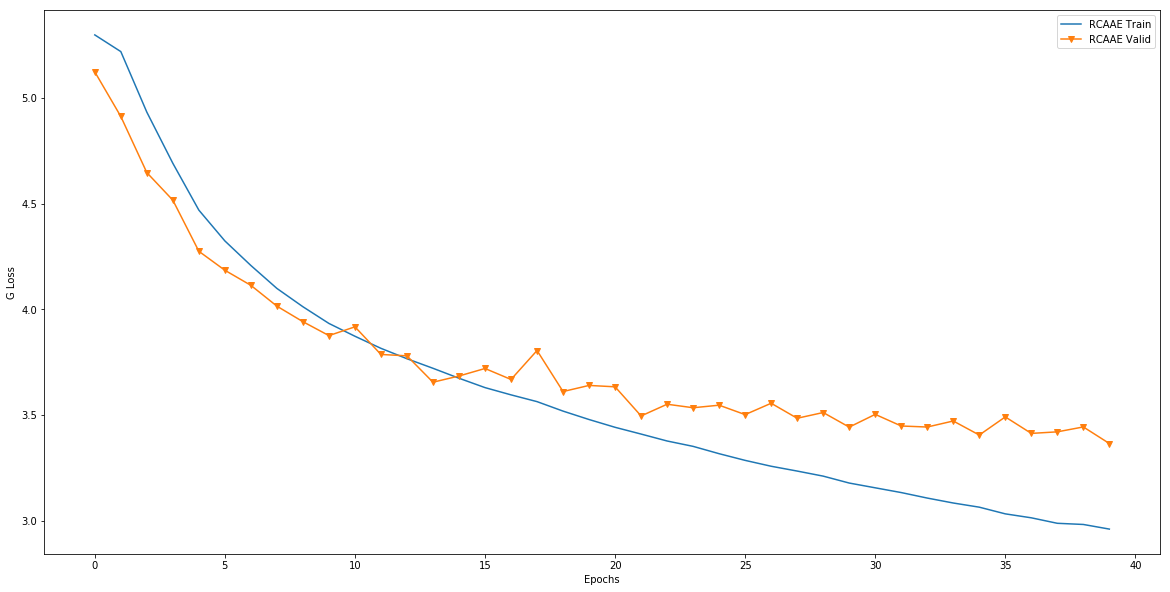

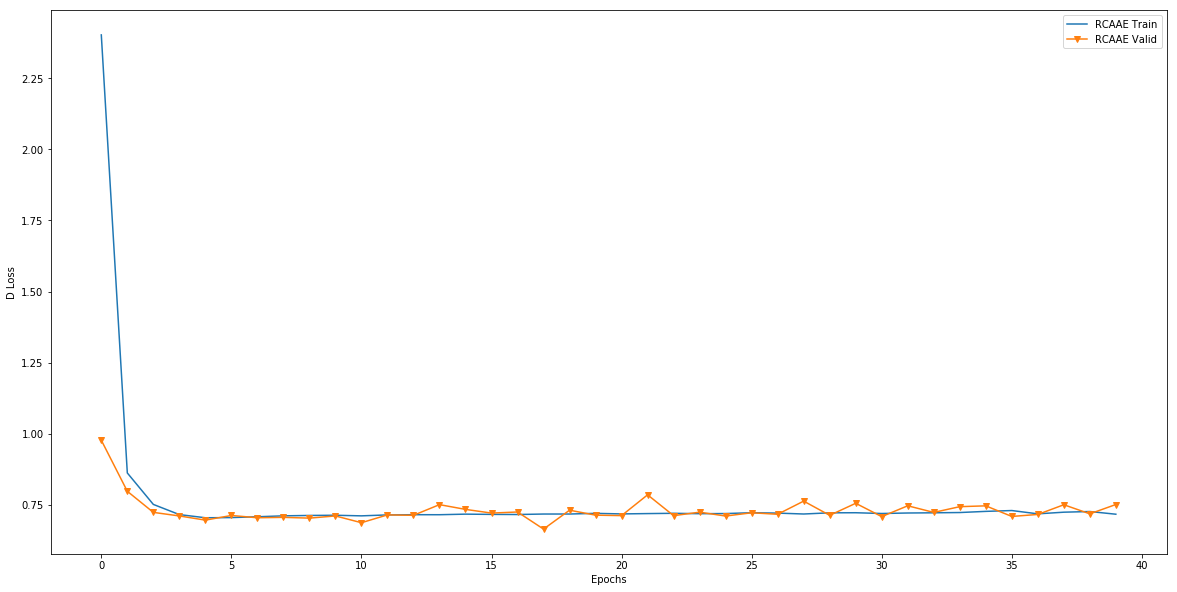

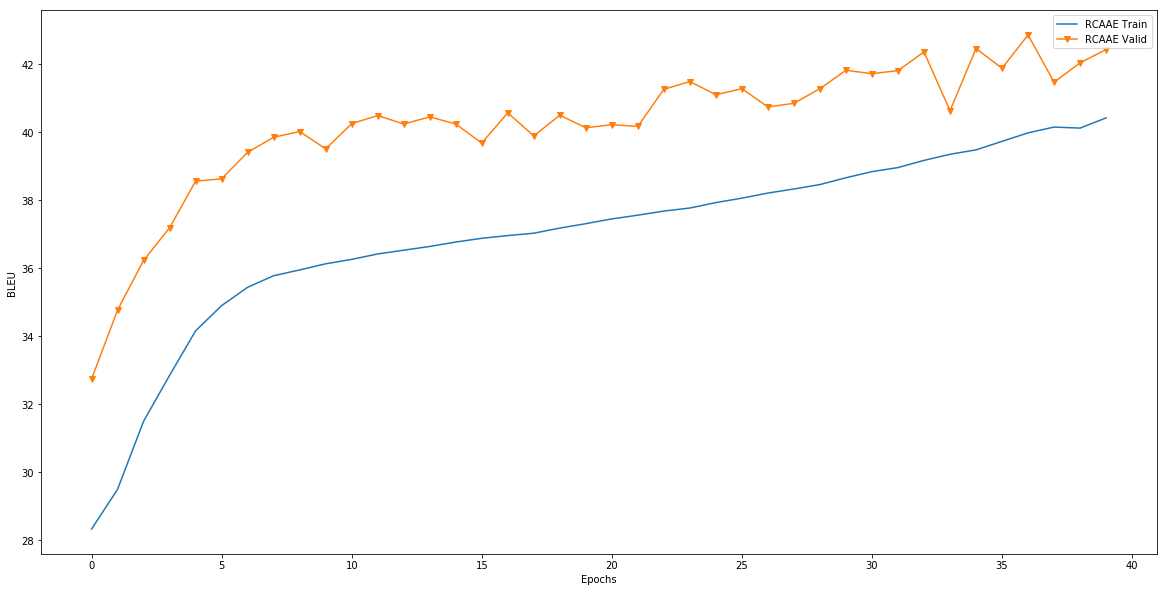

========== Start epoch 41 at 03:23:07 ==========
Epoch  41 Train: BLEU: 40.67, AE: 2.24506, G: 2.92761, D: 0.72243 at 03:31:03
Epoch  41 Valid: BLEU: 42.68, AE: 2.72448, G: 3.37620, D: 0.72684 at 03:31:13

Origin:
	to fill up this last can , man will i survive in this climate or what ?
	they said i was washed up , and got a blood bath
	i 'm not a rapper , i 'm an adapter , i can adjust
	plus i can just walk up to a mic and just bust <eos>

Decoded: and i 'm signin ' cds and nostalgia , i 'm a fiend
	i 'm a fiend , i 'm a fiend , i 'm a fiend
	i 'm tired of being knots , i 'm like a snail
	i 'm tired of being knots , i 'm a fiend , <eos>
	

Random sample:

Decoded w. style E:
	and i 'm a doberman , pinch a little bit of dignity
	i 'm a fiend
	and i 'm a compulsive liar
	i 'm tired of being a fucking elevator <eos>

Decoded w. style M:
	a young boy is playing with a toy on a skateboard .
	two men are playing on a stage .
	a group of people are standing on a bench in front of a building .

Epoch  50 Train: BLEU: 42.54, AE: 2.06889, G: 2.74365, D: 0.73084 at 04:43:34
Epoch  50 Valid: BLEU: 43.53, AE: 2.68108, G: 3.21525, D: 0.80409 at 04:43:44

Origin:
	a man in a red dress coat riding a white horse in sand .
	upset woman in a blue dress walking in a city .
	a security guard standing alone by a building wall . <eos>

Decoded: a man in a blue shirt and a woman in black , white , and black , and black , are playing soccer , and are playing instruments .
	a man in a blue shirt is standing
	

Random sample:

Decoded w. style E:
	it 's the longest , i 'm the sheppard
	the plan is the prime maestro , i 'm a fiend
	i 'm tired of faking knots with a tapeworm
	i 'm tired of being judged <eos>

Decoded w. style M:
	three men are playing on a beach .
	two men are playing on a stage with a guitar in the background .
	a group of people are standing in front of a large building . <eos>

========== Start epoch 51 at 04:43:45 ==========
Epoch  51 Train: BLEU: 42.66, AE: 2.05647, G: 2.744


Decoded w. style M:
	an older man is playing the guitar on stage .
	a group of people are standing in front of a building with their maps and food .
	two men are playing a game of monopoly . <eos>

========== Start epoch 59 at 05:48:03 ==========
Epoch  59 Train: BLEU: 44.28, AE: 1.92494, G: 2.60140, D: 0.73266 at 05:55:53
Epoch  59 Valid: BLEU: 43.91, AE: 2.65633, G: 3.30372, D: 0.74194 at 05:56:03

Origin:
	an ump in black watches a baseball game .
	a cheerleader dressed in an orange and white outfit is tossed in the air by four other cheerleaders on the ground .
	woman is showing a large star of david to young students . <eos>

Decoded: an older man is standing on a sidewalk with a large piece of paper on his head .
	a group of people are standing in front of a crowd of people .
	two men are playing in a soccer game , one is playing
	

Random sample:

Decoded w. style E:
	and i do n't know how to do is , he 's the bad
	he 's just a desperado , and it 's so bad
	but i do n't mean to

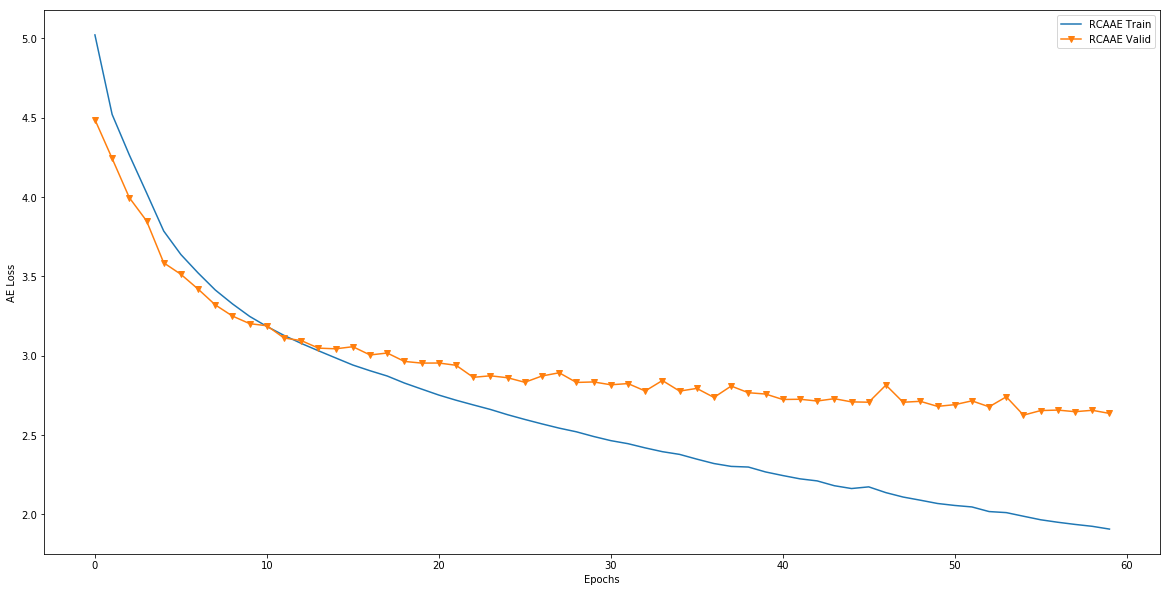

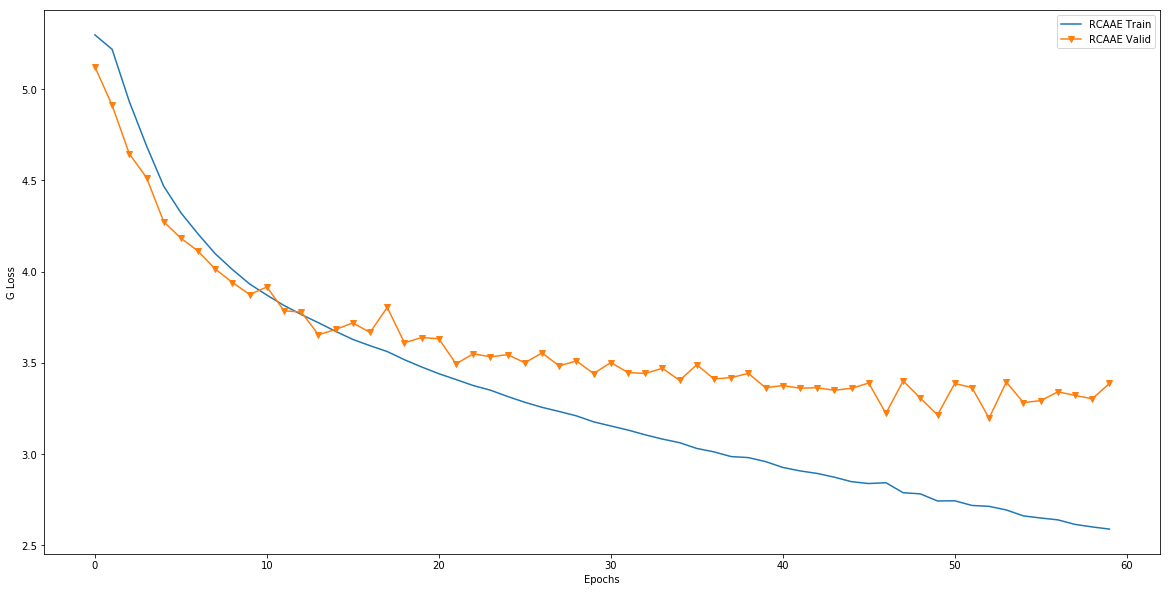

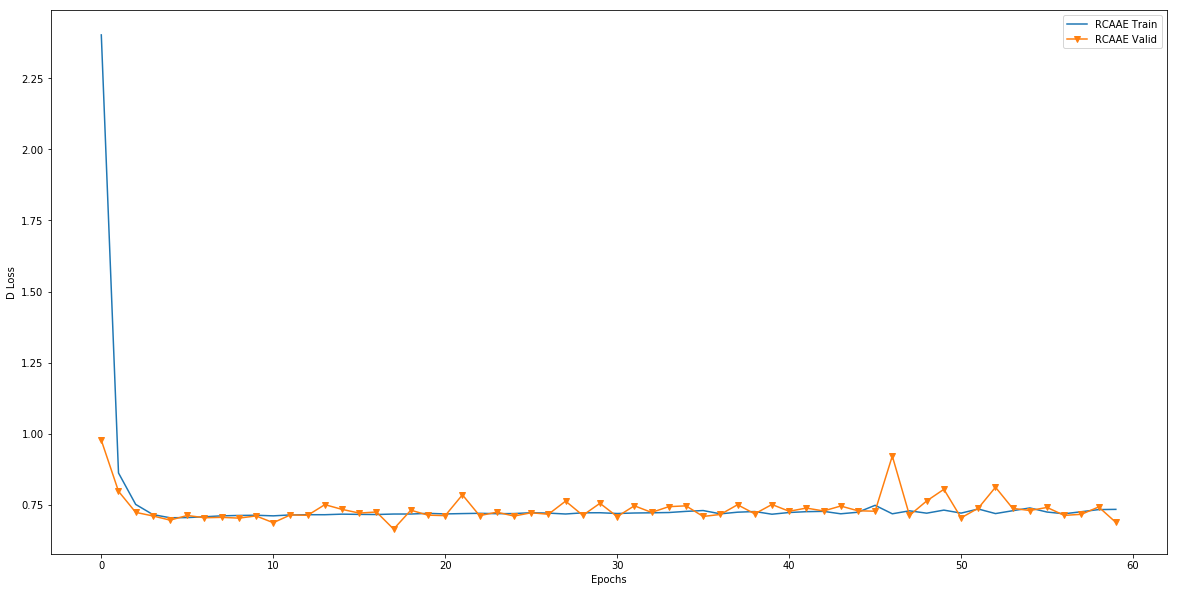

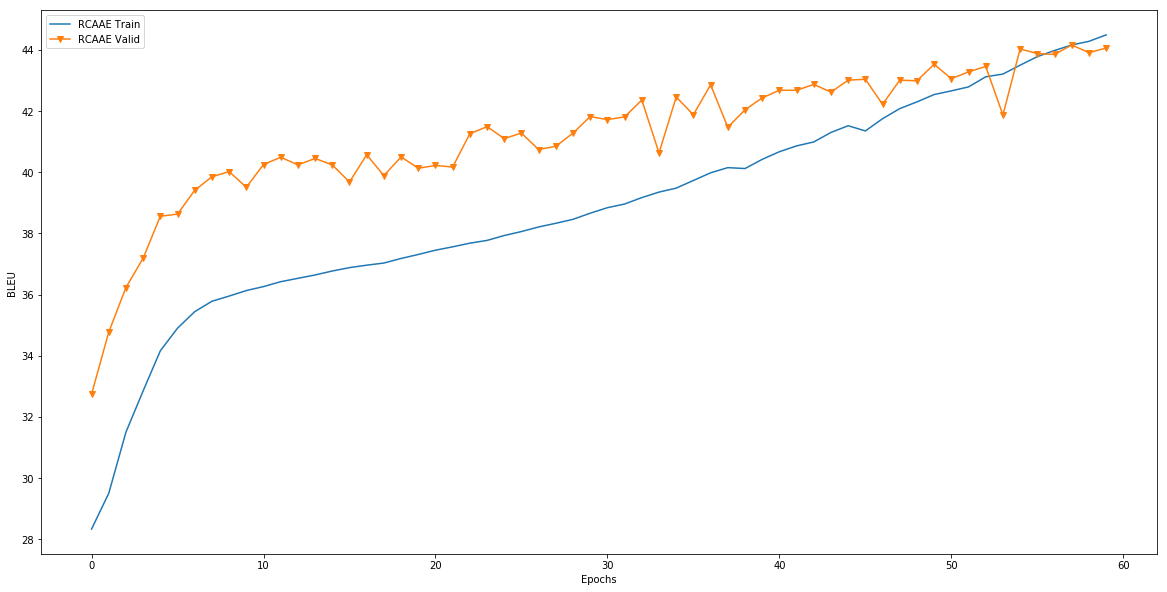

========== Start epoch 61 at 06:04:05 ==========
Epoch  61 Train: BLEU: 44.76, AE: 1.89071, G: 2.57301, D: 0.73435 at 06:11:57
Epoch  61 Valid: BLEU: 44.02, AE: 2.64879, G: 3.28891, D: 0.74091 at 06:12:07

Origin:
	a man jumping in the sand along the shore while holding something in his hand .
	construction in the city at night .
	two police officers in bright yellow uniforms are standing and talking to one another . <eos>

Decoded: a man is standing on the sidewalk with his hands in his hand .
	two men in hard hats and helmets are standing on the side of a road .
	two men are playing a game of a game
	

Random sample:

Decoded w. style E:
	the looniest , zaniest , spontaneous , sporadic
	and i do n't know how much the thing
	but i do n't wanna be responsible for that , so
	put the mic down and walk away <eos>

Decoded w. style M:
	the group of people are standing on a stage with their arms .
	a man is standing on a ladder with his hands on his head .
	a man is sitting on a bench with 

Epoch  70 Train: BLEU: 46.41, AE: 1.76845, G: 2.44358, D: 0.73666 at 07:24:11
Epoch  70 Valid: BLEU: 44.24, AE: 2.63696, G: 3.27833, D: 0.74129 at 07:24:21

Origin:
	we 're the ones who chicka made you
	back by popular demand
	now pop a little zantac or ant ' acid if you can
	you 're ready to tackle any task that is at hand <eos>

Decoded: you 're the only one of the world who do n't know
	i 'm tired of all a couple of months
	i 'm tired of being fired
	but i 'm a broke one , i 'm
	

Random sample:

Decoded w. style E:
	and i 'm devastating one who made it , but it 's all to say
	i 'm just a hooligan who 's on my way
	i 'm a criminal
	'coz i 'm a criminal
	i 'm the

Decoded w. style M:
	a woman is holding her hand while sitting on a bench .
	a young boy is sitting on a couch with a blue bag and a blue jacket on her head .
	a man is sitting on a bench

========== Start epoch 71 at 07:24:21 ==========
Epoch  71 Train: BLEU: 46.70, AE: 1.74820, G: 2.42983, D: 0.73707 at 07:32:12
Epoch  71

Epoch  79 Train: BLEU: 48.12, AE: 1.65148, G: 2.33375, D: 0.73476 at 08:36:10
Epoch  79 Valid: BLEU: 45.88, AE: 2.55553, G: 3.22429, D: 0.72794 at 08:36:20

Origin:
	a female washes her medium sized dog outdoors in a plastic container while a friend secures it with a leash .
	a kid jumping into a pool of water .
	child in black jacket , red pants and fleece had sleeps on a red jacket . <eos>

Decoded: a couple of people on the street , one is wearing a red shirt and the other wearing a baggie shirt .
	two men are playing soccer .
	a young boy is jumping over a wooden mound , while another man watches him . <eos>
	

Random sample:

Decoded w. style E:
	when i 'm gone , i 'm just the same one of the shit
	i 'm sick of being judged , i 'm a criminal
	but i 'm a criminal , i 'm a change it , i 'm

Decoded w. style M:
	a little girl in a bathing suit is jumping over the water with her hands in her mouth .
	a man in a black shirt and black pants is standing on a rock ledge .
	a group of peop

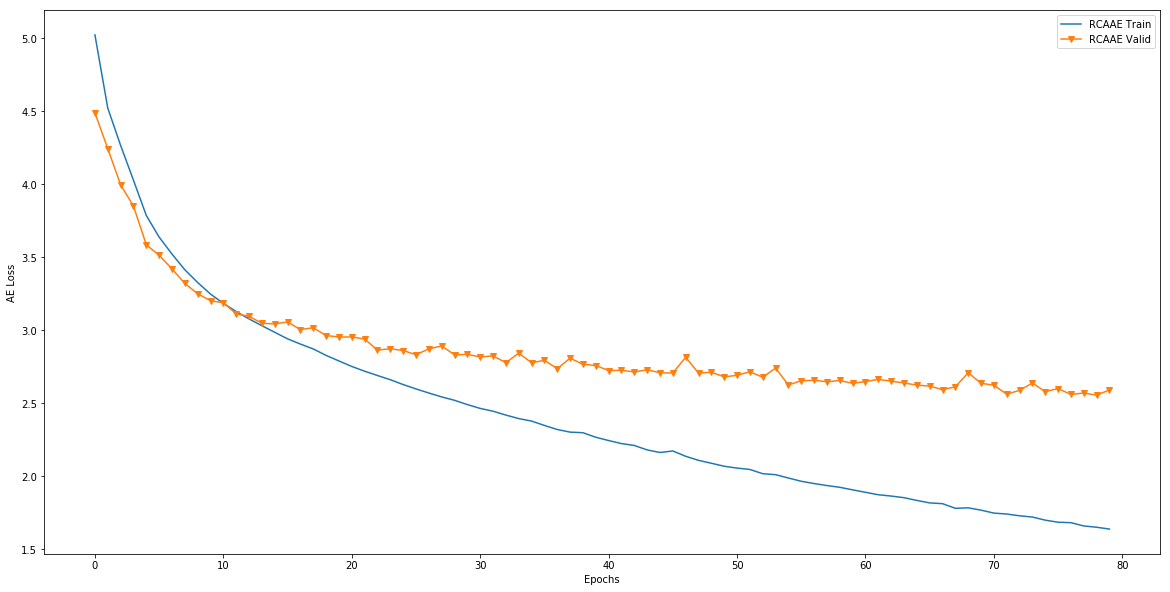

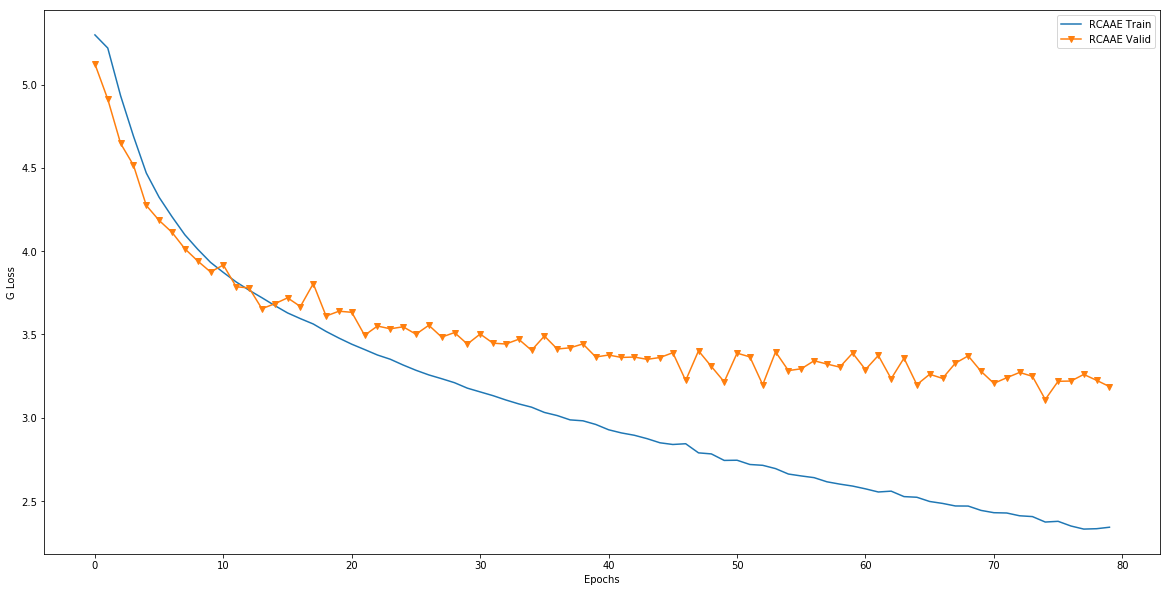

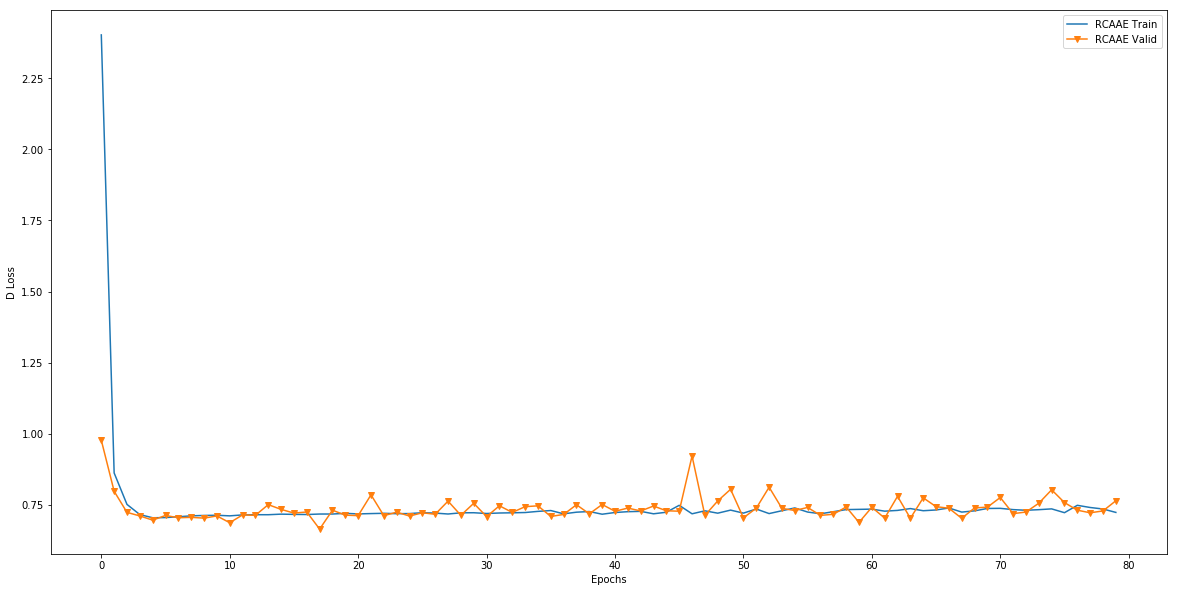

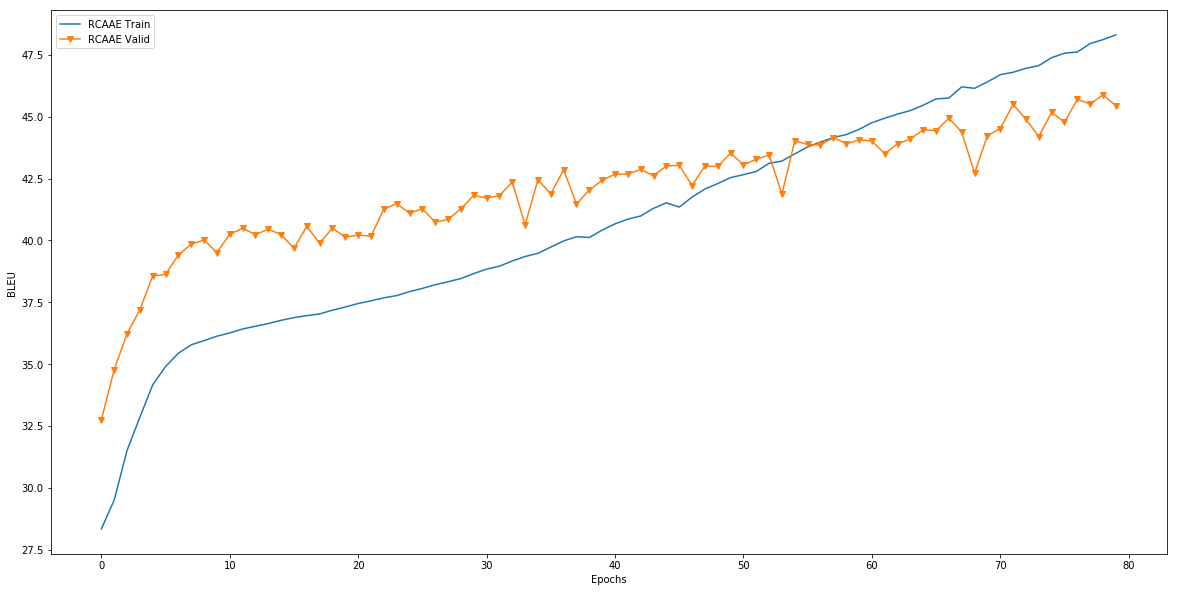

========== Start epoch 81 at 08:44:19 ==========
Epoch  81 Train: BLEU: 48.38, AE: 1.63308, G: 2.30276, D: 0.73817 at 08:52:05
Epoch  81 Valid: BLEU: 45.45, AE: 2.56573, G: 3.23077, D: 0.73818 at 08:52:15

Origin:
	a snow covered landscape with light fixtures and a red fence .
	people hiking through an icy , hilly landscape .
	three men , dressed in rain gear are standing on the dock of a boat preparing to clean fish . <eos>

Decoded: a male gymnast is jumping over a rail in the ocean .
	two men are sitting on a bench , one of them is standing on the side of the road .
	two men in hard hats and safety harnesses <eos>
	

Random sample:

Decoded w. style E:
	but i do n't give a fuck
	so put the mic down and walk away
	you can still have a little bit of dignity
	i would never claim to be no , ray benzino <eos>

Decoded w. style M:
	a woman is sitting on a bench in front of a building .
	two men are working on a carpentry project .
	a man on the street is riding his bike down a dirt road .


Decoded w. style M:
	a man in a black jacket and hat is standing on a sidewalk .
	a group of people are standing around a table with drinks .
	two men in a martial arts match in a field . <eos>

========== Start epoch 90 at 09:55:58 ==========
Epoch  90 Train: BLEU: 50.03, AE: 1.53146, G: 2.23266, D: 0.72715 at 10:03:45
Epoch  90 Valid: BLEU: 46.27, AE: 2.57259, G: 3.26297, D: 0.71714 at 10:03:54

Origin:
	we lyrically oughta bury you beneath the dirt when
	you fuck with a label overseein ' the earth
	shady muthafucka , o. trice 's birth
	and as i mold , i become a curse <eos>

Decoded: we 'll never go to the point , you 're gon na go
	hit the corner of the lake , it 's the size of a peanut
	the disaster is the wrong thing , the world
	

Random sample:

Decoded w. style E:
	it 's like a verbal seduction
	i 'm everlasting , i melt vanilla ice like silicone
	i 'm a criminal
	i 'm nicer than pete , but i 'm just the baddest to the top <eos>

Decoded w. style M:
	people are walking on a s


Decoded w. style M:
	an older man is sitting on a bench with his head crossed .
	a man is standing on the sidewalk and is trying to climb a calf .
	a group of people are sitting in a circle outside .

========== Start epoch 99 at 11:07:33 ==========
Epoch  99 Train: BLEU: 51.86, AE: 1.42704, G: 2.08936, D: 0.74367 at 11:15:26
Epoch  99 Valid: BLEU: 46.96, AE: 2.56325, G: 3.21610, D: 0.73728 at 11:15:36

Origin:
	i spent so much energy on it , honestly i 'm exhausted
	i 'm so caught it i almost feel like i 'm the one who caused it
	this ai n't what i 'm in hip hop for , it 's not why i got in it
	now it 's never my object to for someone to get killed <eos>

Decoded: i 'm tired of being fired , so i 'm signin ' the sacred piper
	all i 'm a man , i 'm the sheisse , fuck it , i 'm the only one
	i 'm not afraid , i 'm on the mic , so let me entertain you
	my lyrical content contains subject matter <eos>
	

Random sample:

Decoded w. style E:
	but i 've been patiently waiting
	but i 'm a mi

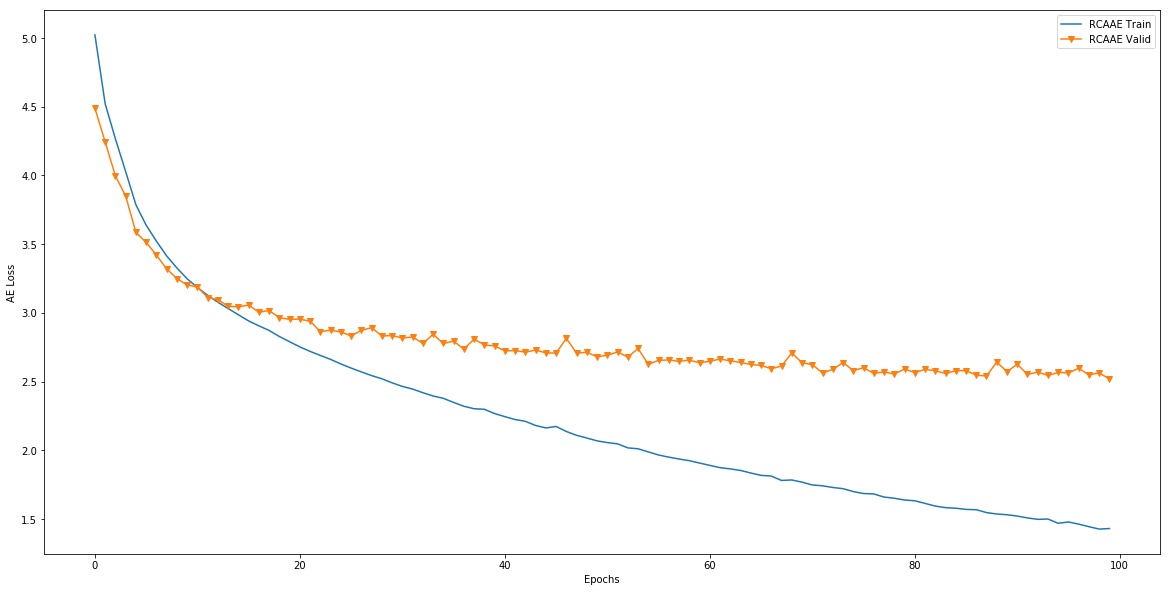

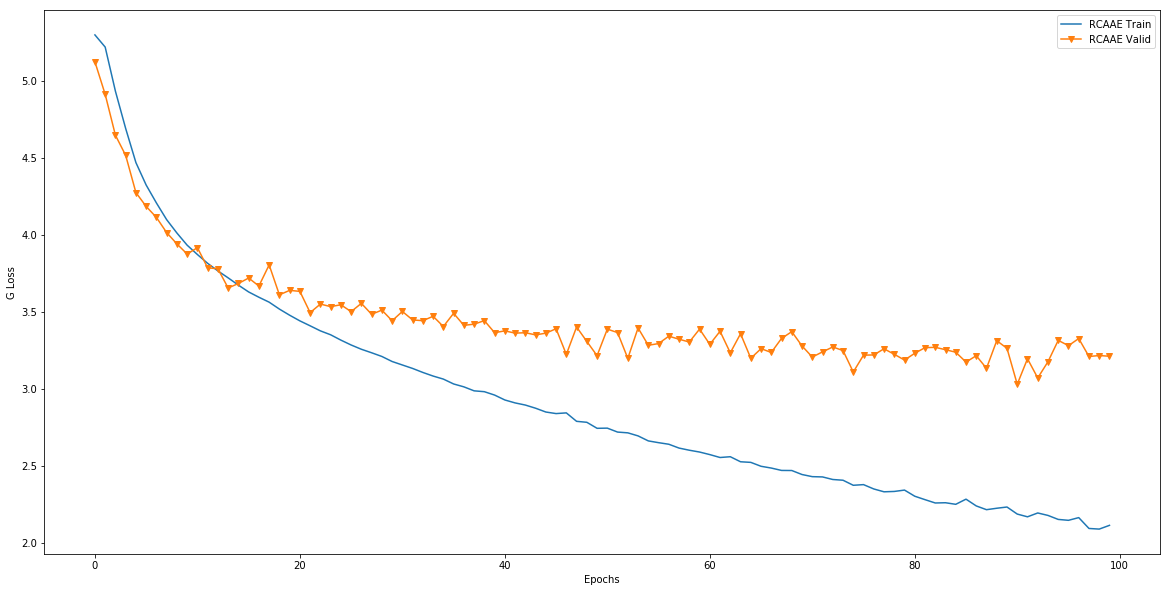

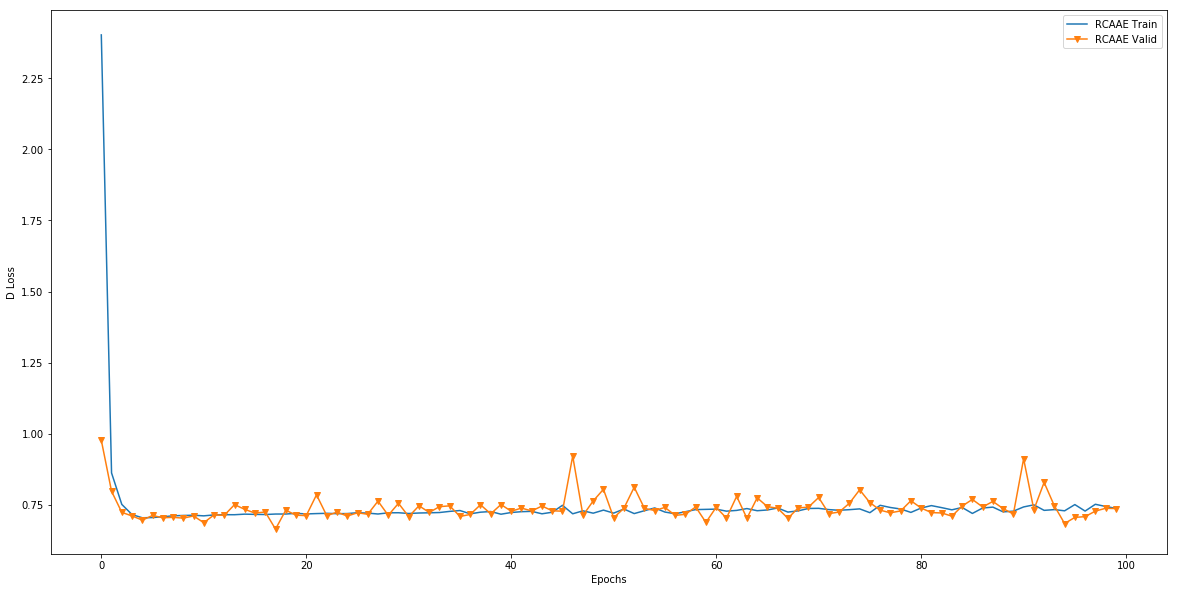

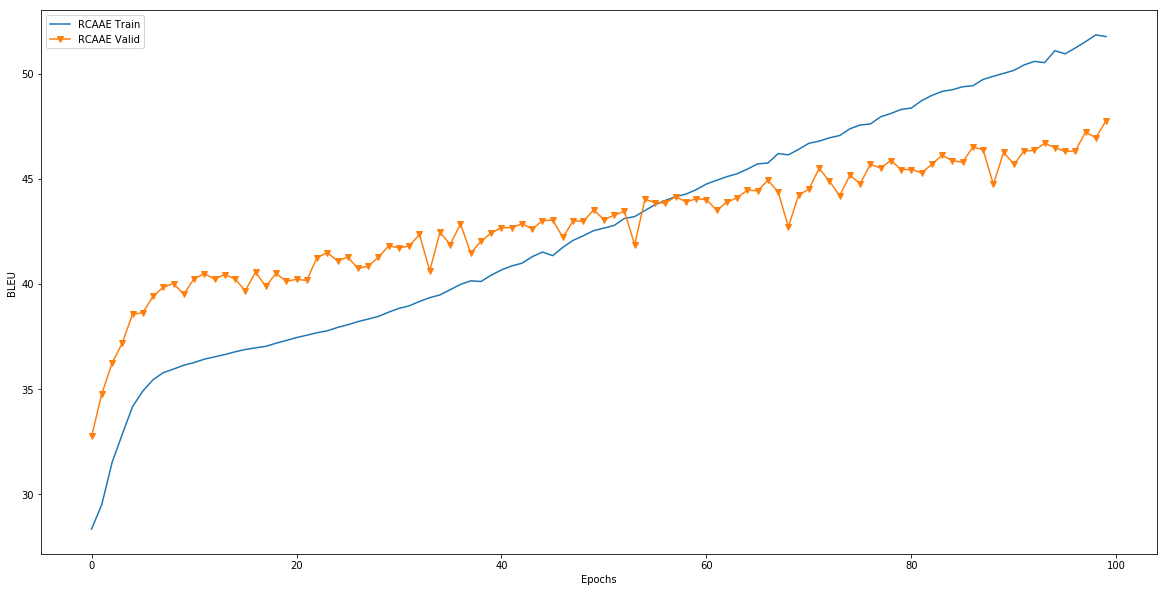

In [16]:
for epoch in range(1, 101):
    print("========== Start epoch {} at {} ==========".format(epoch, datetime.now().strftime("%H:%M:%S")))
    trn, val, _ = metrics[model_name]
    trn.append(train(epoch, enc, dec, disc, prior_size, train_dl, TEXT.vocab, device))
    val.append(validate(epoch, enc, dec, disc, prior_size, valid_dl, TEXT.vocab, device))

    print_decoded(enc, dec, gen_dl, vocab=TEXT.vocab, device=device)
    print_sample(dec, sample_size=prior_size, max_seq_len=41, vocab=TEXT.vocab,
                 style_vocab=LABEL.vocab, device=device)
    
    if epoch % 20 == 0: 
        plot_metrics(metrics, 0, 'AE Loss')
        plot_metrics(metrics, 1, 'G Loss')
        plot_metrics(metrics, 2, 'D Loss')
        plot_metrics(metrics, 3, 'BLEU')
        


In [17]:
torch.save(enc.state_dict(), 'rcaae.enc.e100.pt')

In [18]:
torch.save(dec.state_dict(), 'rcaae.dec.e100.pt')

In [19]:
torch.save(disc.state_dict(), 'rcaae.disc.e100.pt')